In [38]:
import numpy as np
import matplotlib.pyplot as plt
import csv

np.random.seed(0)

In [39]:
""" IMPORTING DATA """

def import_data(file_name):
    data = []
    label = []
    with open(file_name, 'r') as csvfile:
        csvreader = csv.reader(csvfile)

        # skip first row because it has labels
        next(csvreader)
        data_indices = [1,2,3,4,5,7,8,9,10]
        class_index = 6

        for row in csvreader:
            data.append([row[i] for i in data_indices])
            label.append(row[class_index])

    # Convert the list to a numpy array
    data_array = np.array(data)

    # add bias
    bias = np.ones((len(data_array), 1))
    data_array = np.hstack((bias, data_array))

    data_array = data_array.astype(np.float32)
    label_array = np.array(label)
    label_array = label_array.astype(np.float32)
    print(f'label shape: {label_array.shape}')

    # here, we're setting the label to be 1 if a positive quantity is in label, otherwise it's -1
    label_array = np.where(label_array > 0.01, 1, -1)
    label_array = np.reshape(label_array, (len(label_array), 1))

    class_a_count = np.sum(label_array == -1)
    class_b_count = np.sum(label_array == 1)
    # baseline accuracy is the percentage of majority class, which is accuracy score we compare to indicate the model actually learned something useful
    print(f'label statistics: class A {class_a_count}, class B {class_b_count}, baseline accuracy: {np.maximum(class_a_count, class_b_count)/(len(data_array))}')
    return data_array, label_array

def split_data(X, Y, test_ratio):
    num_test = int(len(X) * test_ratio)
    test_indices = np.random.choice(len(X), num_test, replace=False)
    Xtest = X[test_indices, :]
    Ytest = Y[test_indices, :]

    X = np.delete(X, test_indices, axis=0)
    Y = np.delete(Y, test_indices, axis=0)
    return X, Y, Xtest, Ytest

In [40]:
class NeuralNetwork():

    def __init__(self, layer_sizes):
        self.weights = []

        # initializing weights to small random values
        for i in range(1, len(layer_sizes)):
            self.weights.append(np.random.rand(layer_sizes[i], layer_sizes[i - 1]) * 0.1)
    
    def tanh(self, x):
        return np.tanh(x)

    def d_tanh(self, x):
        return 1 - np.power(np.tanh(x), 2)

    def output_func(self, X):
        return np.sign(X)
    
    # returns the final classification result
    def predict(self, X):
        A_0 = X.T
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        A_2 = self.output_func(A_2.T)
        return A_2
    
    # returns full history of forward so we can perform backpropagation
    def forward(self, X):
        A_0 = X
        A_1 = self.weights[0] @ A_0
        A_1 = self.tanh(A_1)
        A_2 = self.weights[1] @ A_1
        return (A_0, A_1, A_2)
    
    def backward(self, X, Y):
        A_0 = X
        A_0 = A_0.reshape((len(A_0), 1))

        # forward propagation
        A_0, A_1, A_2 = self.forward(A_0)

        # backward: error of output layer
        dA_2 = A_2 - Y

        # backward: compute weight gradient of layers
        dW_1 = dA_2 @ A_1.T
        dA_1 = self.weights[1].T @ dA_2 * self.d_tanh(A_1)
        dW_0 = dA_1 @ A_0.T

        # final gradient
        weight_gradients = [dW_0, dW_1]
        return weight_gradients

    
    def train(self, X, Y, total_epoch, learning_rate=0.03, learning_rate_decay=0.8):
        print("beginning training")
        accuracy_history = np.zeros((total_epoch + 1,))
        for epoch in range(total_epoch):

            # variable learning rate adjustment
            # TODO: better decay algorithm, such as checking error slope
            if epoch % (total_epoch // 10) == 0:
                learning_rate *= learning_rate_decay
                print(f"epoch {epoch} with learning rate {np.around(learning_rate, 4)}")

            for i in range(0, len(X)):

                weight_gradients = self.backward(X[i], Y[i])
                # subtract the gradient from the weights
                for j in range(len(self.weights)):
                    self.weights[j] -= learning_rate * weight_gradients[j]

            accuracy = self.test(X, Y)
            accuracy_history[epoch + 1] = accuracy
            if epoch % (total_epoch // 10) == 0:
                print(f'training accuracy: {np.around(accuracy, 5)}')
        
        return accuracy_history
            

    def test(self, X, Y):
        results = self.predict(X)
        num_incorrect = np.sum(np.abs(0.5 * (Y - results)))
        accuracy = 1 - (num_incorrect/len(X))
        return accuracy

    def correct(self, x, ans):
        return np.sign(x) == np.sign(ans)

label shape: (3654,)
label statistics: class A 2079, class B 1575, baseline accuracy: 0.5689655172413793
Shapes: X: (3289, 10), Y: (3289, 1), Xtest: (365, 10), Ytest: (365, 1)
beginning training
epoch 0 with learning rate 0.0065
training accuracy: 0.72089
epoch 10 with learning rate 0.0042
training accuracy: 0.74217
epoch 20 with learning rate 0.0027
training accuracy: 0.7443
epoch 30 with learning rate 0.0018
training accuracy: 0.7446
epoch 40 with learning rate 0.0012
training accuracy: 0.74977
epoch 50 with learning rate 0.0008
training accuracy: 0.74977
epoch 60 with learning rate 0.0005
training accuracy: 0.75068
epoch 70 with learning rate 0.0003
training accuracy: 0.7516
epoch 80 with learning rate 0.0002
training accuracy: 0.75464
epoch 90 with learning rate 0.0001
training accuracy: 0.75403


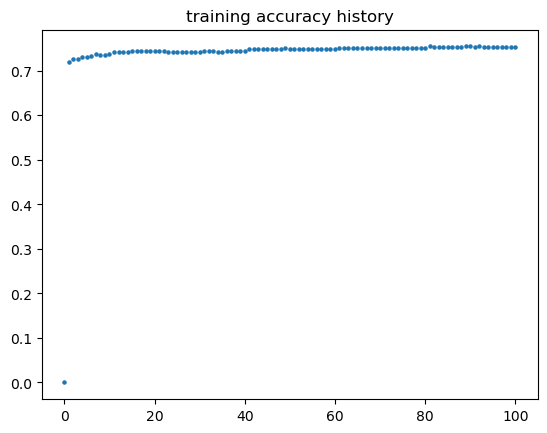

TESTING ACCURACY: 0.7424657534246575


In [41]:
"""TESTING"""

file = '../../Data/weather/weather_prediction_dataset.csv'
X, Y = import_data(file)

def custom_nn():
    Xtrain, Ytrain, Xtest, Ytest = split_data(X, Y, 0.1)
    print(f'Shapes: X: {Xtrain.shape}, Y: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')
    network1 = NeuralNetwork([10, 20, 1])
    total_epoch = 100
    error_graph = network1.train(Xtrain, Ytrain, total_epoch, 0.01, 0.65)

    # plotting training accuracy
    plt.scatter(np.linspace(0, total_epoch, len(error_graph)), error_graph, s=5)
    plt.title("training accuracy history")
    plt.show()

    accuracy = network1.test(Xtest, Ytest)
    print(f"TESTING ACCURACY: {accuracy}")

custom_nn()

In [42]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cpu


In [43]:
class SimpleDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [44]:
class FC(nn.Module):

    def __init__(self, in_dim, out_dim, num_hidden_layers, layer_size):
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.layer_size = layer_size

        self.layer_list = nn.ModuleList()

        self.layer_list.append(nn.Linear(self.in_dim, self.layer_size))
        self.num_hidden_layers = num_hidden_layers

        for i in range(1, self.num_hidden_layers):
            self.layer_list.append(nn.Linear(self.layer_size, self.layer_size))

        self.layer_list.append(nn.Linear(self.layer_size, self.out_dim))

    def forward(self, x):

        x = x.view(-1, self.in_dim)

        for i in range(self.num_hidden_layers):
            x = F.relu(self.layer_list[i](x))

        return self.layer_list[self.num_hidden_layers](x)

In [45]:
import torch.optim as optim

def test(net, loader, device):
    net.eval()

    test_loss = 0
    incorrect = 0
    total = 0

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = net(data)

            pred = output.cpu().detach().numpy()
            pred = np.sign(pred)

            total = total + 1

            answer = target.cpu().detach().numpy()
            incorrect += 0.5 * np.sum(np.abs(pred - answer))
    
    accuracy = 1 - (incorrect / len(loader.dataset))
    print(f'Test loss: {test_loss}, accuracy: {accuracy}')

    return accuracy


def train(net, loader, optimizer, device, log_interval=100):
    # prepare model for training (only important for dropout, batch norm, etc.)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    net.train()
    incorrect = 0
    total = 0
    for batch_num, (data, target) in enumerate(loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        pred = outputs.cpu().detach().numpy()
        pred = np.sign(pred)

        #print(f'output: {outputs}')
        # TODO: USE OUTPUTS DIRECTLY RATHER THAN PRED
        
        #pred = outputs.data.max(1, keepdim=True)[1]
        answer = target.cpu().detach().numpy()
        incorrect += 0.5 * np.sum(np.abs(pred - answer))
        total += len(outputs)

        if batch_num % log_interval == 0:
            print(f'\taccuracy: {1 - (incorrect / total)}')

    print(f'\tfinal training accuracy: {1 - (incorrect / len(loader.dataset))}')

In [46]:
def torch_nn():
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1, random_state=0)
    print(f'Shapes: X: {Xtrain.shape}, Y: {Ytrain.shape}, Xtest: {Xtest.shape}, Ytest: {Ytest.shape}')
    
    # hyperparameters
    train_batch_size = 10
    test_batch_size = 10
    total_epoch = 10
    learning_rate = 0.1
    
    input_dim = 10
    out_dim = 1
    num_hidden_layers = 3
    layer_size = 30

    # PREPARING DATA

    # Convert to torch tensors
    Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
    Ytrain = torch.tensor(Ytrain, dtype=torch.float32)
    Xtest = torch.tensor(Xtest, dtype=torch.float32)
    Ytest = torch.tensor(Ytest, dtype=torch.float32)

    # Create Dataset objects, then create torch dataloader
    train_dataset = SimpleDataset(Xtrain, Ytrain)
    test_dataset = SimpleDataset(Xtest, Ytest)

    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

    # CREATING NEURAL NETWORK OBJECT
    network = FC(in_dim=input_dim, out_dim=out_dim, num_hidden_layers=num_hidden_layers, layer_size=layer_size)
    network = network.to(device)
    optimizer = optim.Adam(network.parameters(), lr=learning_rate)

    # TRAINING
    for epoch in range(total_epoch):
        print(f'Training epoch: {epoch}')
        train(network, train_loader, optimizer, device)

    # TESTING
    print("Testing")
    test(network, test_loader, device)
    

torch_nn()

Shapes: X: (3288, 10), Y: (3288, 1), Xtest: (366, 10), Ytest: (366, 1)
Training epoch: 0
	accuracy: 0.5


	accuracy: 0.5584158415841585
	accuracy: 0.5527363184079602
	accuracy: 0.5441860465116279
	final training accuracy: 0.5395377128953771
Training epoch: 1
	accuracy: 0.4
	accuracy: 0.5495049504950495
	accuracy: 0.5492537313432836
	accuracy: 0.5438538205980066
	final training accuracy: 0.5395377128953771
Training epoch: 2
	accuracy: 0.8
	accuracy: 0.5346534653465347
	accuracy: 0.5432835820895523
	accuracy: 0.5435215946843854
	final training accuracy: 0.5395377128953771
Training epoch: 3
	accuracy: 0.8
	accuracy: 0.5564356435643565
	accuracy: 0.5477611940298508
	accuracy: 0.5345514950166113
	final training accuracy: 0.5395377128953771
Training epoch: 4
	accuracy: 0.6
	accuracy: 0.5316831683168317
	accuracy: 0.535820895522388
	accuracy: 0.5395348837209302
	final training accuracy: 0.5395377128953771
Training epoch: 5
	accuracy: 0.30000000000000004
	accuracy: 0.5475247524752476
	accuracy: 0.5422885572139303
	accuracy: 0.5421926910299003
	final training accuracy: 0.5395377128953771
Training e